In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### LOAD DATA

In [ ]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display
%tensorflow_version 1.x
%matplotlib inline

input_data_length = 100
model_num = 131
num_classes = 2

gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/'


Made_X = np.load(gdrive_path + 'Made_X/Made_X %s_%s.npy' % (input_data_length, model_num))
Made_Y = np.load(gdrive_path + 'Made_X/Made_Y %s_%s.npy' % (input_data_length, model_num)).reshape(-1, 1)


#       dataset 분리      #
print(Made_X.shape)
print(Made_Y.shape)

row = Made_X.shape[1]
col = Made_X.shape[2]
print(row, col)

TensorFlow 1.x selected.
(3027, 100, 18)
(3027, 1)
100 18


### DATA CHECK

In [ ]:
for i in range(len(Made_X)):
  if Made_Y[i] == 1:
    print(i)
    plt.plot(Made_X[i][:, [0, 1, 2, 3, 4, 5, 6]])
    plt.show()
    # print()
  # break


In [ ]:
for i in range(len(Made_X)):
  if Made_Y[i] == 0:
    print(i)
    plt.plot(Made_X[i][:, [0, 1, 2, 3, 4, 5, 6]])
    plt.show()
    # print()
  # break


### FEATURE IMPORTANCE

In [ ]:
ohlcv_ma_st_X = Made_X[:, :, :7]

plus_trix = Made_X[:, :, :8]
plus_macd = Made_X[:, :, [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]]
plus_macd1 = Made_X[:, :, [0, 1, 2, 3, 4, 5, 6, 8, 9]]
plus_macd2 = Made_X[:, :, [0, 1, 2, 3, 4, 5, 6, 10]]

plus_fisher = Made_X[:, :, [0, 1, 2, 3, 4, 5, 6, 11, 12]]
plus_stoch = Made_X[:, :, [0, 1, 2, 3, 4, 5, 6, 13, 14]]
plus_stochrsi = Made_X[:, :, [0, 1, 2, 3, 4, 5, 6, 15, 16, 17]]

# Made_X_list = [ohlcv_ma_st_X, plus_trix, plus_macd, plus_fisher, plus_stoch, plus_stochrsi]
# Made_X_list = [plus_macd, plus_macd2]
# Made_X_list = [plus_macd]
Made_X_list = [plus_stoch]

### Data Simplification Example

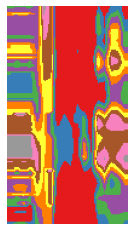

(-0.5, 179.5, 99.5, -0.5)

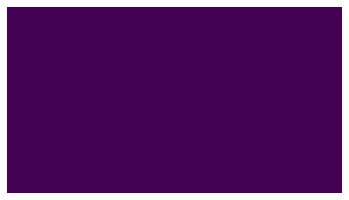

In [ ]:
import cv2

# data = Made_X[0][:, [0, 1, 2, 3, 4, 5, 6]]
data = Made_X[0]
temp_r = data.shape[0]
temp_c = data.shape[1]
resized = cv2.resize(data, (temp_r * 1, temp_c * 10))
cmapped = plt.cm.Set1(resized)
plt.imshow(cmapped)
plt.axis('off')
plt.show()
plt.imshow(cmapped[:, :, [3]].reshape(temp_r * 1, temp_c * 10))
plt.axis('off')

# print(resized)
# print('-----------------------')
# print(cmapped[:, :, :3])

### MODEL DEFINE

In [ ]:
from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2


def FER_Model(input_shape=(row, col, 1)):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_1 = net

    net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(128)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs=visible, outputs=net)
    # summary layers
    print(model.summary())
    
    return model

Using TensorFlow backend.


### PREDICTION

(3027, 90, 100, 3)
(2118, 90, 100, 3)
(909, 90, 100, 3)
{0: 0.6668765743073047, 1: 1.9981132075471697}
(2118, 2)
(909, 2)


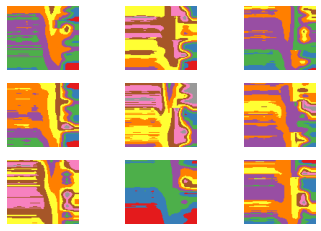

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 90, 100, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 100, 256)      7168      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 90, 100, 256)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 100, 128)      295040    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 90, 100, 128)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 100, 64)       73792     
____________________________________________

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight
import cv2


for model_i, Made_X in enumerate(Made_X_list):

  row = Made_X.shape[1]
  col = Made_X.shape[2]

  #     Data Resizing and Simplication    #
  temp_list = list()
  for data_x in Made_X:
    resized = cv2.resize(data_x, (row * 1, col * 10))
    cmapped = plt.cm.Set1(resized)[:, :, :3]  # Drop Alpha Channel
    temp_list.append(cmapped)
  
  Made_X = np.array(temp_list)
  print(Made_X.shape)
  # break
  
  row = Made_X.shape[1]
  col = Made_X.shape[2]
  rgb = Made_X.shape[3]

  X_train, X_val, Y_train, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
                                                    shuffle=False)

  X_train = X_train.astype('float32').reshape(-1, row, col, rgb)
  X_val = X_val.astype('float32').reshape(-1, row, col, rgb)
  print(X_train.shape)
  print(X_val.shape)

  # print(Y_train[:, 0])
  class_weights = class_weight.compute_class_weight('balanced', 
                                                    np.unique(Y_train[:, 0]),
                                                    Y_train[:, 0])
  class_weights = dict(enumerate(class_weights))
  print(class_weights)
  # quit()

  Y_train_ = Y_train.astype('float32')
  Y_val_ = Y_val.astype('float32')
  Y_train = np_utils.to_categorical(Y_train, num_classes)
  Y_val = np_utils.to_categorical(Y_val, num_classes)
  print(Y_train.shape)
  print(Y_val.shape)
  # break

  datagen = ImageDataGenerator( 
  #     rotation_range = 60,
  #     zoom_range = 0.6,
  #     shear_range = 0.6,
  #     horizontal_flip = True,
  #     width_shift_range=0.6,
  #     height_shift_range=0.6,
      fill_mode = 'nearest'
      )

  testgen = ImageDataGenerator( 
      )
  datagen.fit(X_train)
  batch_size = 16

  for X_batch, _ in datagen.flow(X_train, Y_train, batch_size=9):
  
      for i in range(0, 9): 
          plt.subplot(330 + 1 + i) 
          # resized = cv2.resize(X_batch[i].reshape(row, col), (row * 2, col * 10))
          # cmapped = plt.cm.Set1(resized)
          # plt.imshow(cmapped)
          # plt.imshow(X_batch[i].reshape(row, col))
          plt.imshow(X_batch[i])
          plt.axis('off') 
      plt.show() 
      break
      
  train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size) 
  val_flow = testgen.flow(X_val, Y_val, batch_size=batch_size) 
  # break
  

  #     MODEL PROCES    #


  model = FER_Model(input_shape=(row, col, rgb))
  opt = Adam(lr=0.0001, decay=0.00005)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
  from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
  filepath = gdrive_path + "model/%s_%s_%s.hdf5" % (input_data_length, model_num, model_i)
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
  checkpoint2 = TensorBoard(log_dir=gdrive_path + 'Tensorboard_graph',
                            histogram_freq=0,
                            write_graph=True,
                            write_images=True)
  checkpoint3 = EarlyStopping(monitor='val_loss', patience=50)
  callbacks_list = [checkpoint, checkpoint2, checkpoint3]

  # keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

  # we iterate 200 times over the entire training set
  num_epochs = 300
  history = model.fit_generator(train_flow, 
                      steps_per_epoch=len(X_train) / batch_size, 
                      epochs=num_epochs,  
                      verbose=2,  
                      callbacks=callbacks_list,
                      class_weight=class_weights,
                      validation_data=val_flow,  
                      validation_steps=len(X_val) / batch_size,
                      shuffle=False)

### LOAD MODEL

In [ ]:
from keras.models import load_model
model_i = 0
model = load_model(gdrive_path + 'model/%s_%s_%s.hdf5' % (input_data_length, model_num, model_i))

### PREDICT ACCURACY BY CONFIDENCE IN "TRUE" LABEL

In [ ]:
confidence = 0.5
y_pred_ = model.predict(X_val, verbose=1)
y_pred = np.where(y_pred_[:, [-1]] >= confidence, 1, 0).reshape(-1, )
t_te = np.argmax(Y_val, axis=1)

# print(y_pred_[:5])
# print(Y_val[:5])
# break

total_true = 0
pred_true = 0

#       predict value 존나 높으면 True 일 확률 존나 높은건데, 그게 진짜 True가 맞냐 이걸 알고 싶은거지     #
#       confidence를 만족하는 label이 1인 데이터 안에서 pred 1 / label 1 -> 이걸 도출해면 된다        #

for i in range(len(y_pred)):
  if y_pred[i] == 1:  
    total_true += 1
    if t_te[i] == 1:
      pred_true += 1

print('True label length :', total_true)      
print('Pred label length :', pred_true)
print('Accuracy : %2.f %%' % (pred_true / total_true * 100))

2473/2473 [==============================] - 2s 881us/step
True label length : 496
Pred label length : 124
Accuracy : 25 %


### CORR MAP

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

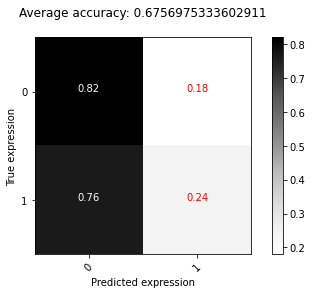

In [ ]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=np.array(('0', '1')),
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir gdrive_path + 'Tensorboard_graph/'

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--host ADDR]
                   [--port PORT] [--purge_orphaned_data BOOL] [--db URI]
                   [--db_import] [--inspect] [--version_tb] [--tag TAG]
                   [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_channel ADDR]
                   [--whatif-use-unsafe-custom-prediction YOUR_CUSTOM_PREDICT_FUNCTION.py]
tensorboard: error: unrecognized arguments: + Tensorboard_graph/